In [1]:
# package imports
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import cv2
from scipy import signal
from scipy.optimize import curve_fit
import scipy.stats as st
import time
import subprocess as sp
from multiprocessing import Pool
import sys
import warnings
from scipy import ndimage
from tqdm.notebook import trange, tqdm
import multiprocessing
from time import time
import json

# module imports
from util.read_data import open_time, find
from util.track_world import sigm_fit_mp

In [2]:
xr.__version__

'0.16.0'

In [3]:
eye_data = xr.open_dataset('/home/eabe/Documents/Github/FreelyMovingEphys/112619_J463b_cricket1clip2_REYE.nc')

In [4]:
longaxis = eye_data.ellipse_param_values.sel(ellipse_params = 'longaxis')
# eye_longaxis= eye_ell_interp_params.sel(ellipse_params='longaxis')
longaxis

<xarray.DataArray 'ellipse_param_values' (frame: 14794)>
array([32.95264 , 32.924751, 32.797357, ...,       nan,       nan,       nan])
Coordinates:
  * frame           (frame) int32 0 1 2 3 4 5 ... 14789 14790 14791 14792 14793
    timestamps      (frame) timedelta64[ns] ...
    trial           object ...
    ellipse_params  <U8 'longaxis'
    cam_center_x    float64 ...
    cam_center_y    float64 ...

In [5]:
data_path = '/home/eabe/Desktop/Test_Data_PreyCapture/demo_pipeline_data/pipeline_config_file/worldcam_test_sets/curated_dataset/'
trial_name = '112619_J463b_cricket1clip2'; side_letter = 'R'
save_path = '/home/eabe/Desktop/Test_Data_PreyCapture/demo_pipeline_data/pipeline_config_file/worldcam_test_sets/Testing/'

eyevidpath = find((trial_name + '*' + side_letter + 'EYE.avi'), data_path)[0]
toptimepath = find(('*' + trial_name + '*' + 'TOP_BonsaiTS.csv'), data_path)[0]
eyetimepath = find(('*' + trial_name + '*' + side_letter + 'EYE_BonsaiTS.csv'), data_path)[0]
worldtimepath = find(('*' + trial_name + '*' + side_letter + 'WORLD_BonsaiTS.csv'), data_path)[0]


In [6]:
%%time

ranger = 10
eyeext = 'REYE'

fig_dir = save_path + '/' + trial_name + '/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# get eye data out of dataset
eye_pts = xr.Dataset.to_array(eye_data).sel(variable='raw_pt_values')
eye_ell_params = eye_data.ellipse_param_values

# open time files
eyeTS = open_time(eyetimepath, np.size(eye_pts, axis=0))
worldTS = open_time(worldtimepath, np.size(eye_pts, axis=0))
topTS = open_time(toptimepath)

# interpolate ellipse parameters to worldcam timestamps
eye_ell_interp_params = eye_ell_params#eye_ell_params.interp_like(xr.DataArray(worldTS), method='linear')

# the very first timestamp
start_time = min(eyeTS[0], worldTS[0], topTS[0])

eye_theta = eye_ell_interp_params.sel(ellipse_params='theta')
eye_phi = eye_ell_interp_params.sel(ellipse_params='phi')
eye_longaxis= eye_ell_interp_params.sel(ellipse_params='longaxis')
eye_shortaxis = eye_ell_interp_params.sel(ellipse_params='shortaxis')
eye_centX = eye_ell_interp_params.sel(ellipse_params='centX')
eye_centY = eye_ell_interp_params.sel(ellipse_params='centY')

eye_raw_theta = eye_ell_params.sel(ellipse_params='theta')
eye_raw_phi = eye_ell_params.sel(ellipse_params='phi')
eye_raw_longaxis= eye_ell_params.sel(ellipse_params='longaxis')
eye_raw_shortaxis = eye_ell_params.sel(ellipse_params='shortaxis')

eyeTSminusstart = [(t-start_time).seconds for t in eyeTS]
worldTSminusstart = [(t-start_time).seconds for t in worldTS]

print('opening video')
eyevid = cv2.VideoCapture(eyevidpath)

# setup the file to save out of this
vidsavepath = os.path.join(fig_dir, str(trial_name + '_pupil_edge_detection_' + eyeext + '.avi'))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vidout = cv2.VideoWriter(vidsavepath, fourcc, 60, (int(eyevid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(eyevid.get(cv2.CAP_PROP_FRAME_HEIGHT))))

set_size = (int(eyevid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(eyevid.get(cv2.CAP_PROP_FRAME_HEIGHT)))

tot = int(eyevid.get(cv2.CAP_PROP_FRAME_COUNT))
# for frame_num in range(0,tot):
frame_num = 10
# read the frame for this pass through while loop
eye_ret, eye_frame = eyevid.read()

# if not eye_ret:
#     break

# # debug with a few frames
# if eyevid.get(cv2.CAP_PROP_POS_FRAMES) > 1:
#     break

cur = str(int(eyevid.get(cv2.CAP_PROP_POS_FRAMES)))

progress = str(int((eyevid.get(cv2.CAP_PROP_POS_FRAMES) / eyevid.get(cv2.CAP_PROP_FRAME_COUNT))*100))
sys.stdout.write('working on pupil in frame {} of {}; now at {}% progress\r'.format(cur, str(tot), progress))
sys.stdout.flush()

eye_frame = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY)

# get ellisepe parameters for this time
# current_time = eyevid.get(cv2.CAP_PROP_POS_FRAMES)
# current_theta = eye_theta.sel(frame=current_time).values[0]
# current_phi = eye_phi.sel(frame=current_time).values[0]
# current_longaxis = eye_longaxis.sel(frame=current_time).values[0]
# current_shortaxis = eye_shortaxis.sel(frame=current_time).values[0]
# current_centX = eye_centX.sel(frame=current_time).values[0]
# current_centY = eye_centY.sel(frame=current_time).values[0]

opening video
CPU times: user 306 ms, sys: 22.4 ms, total: 329 msgress
Wall time: 314 ms


In [7]:
json_config_path = '/home/eabe/Desktop/Test_Data_PreyCapture/demo_pipeline_data/pipeline_config_file/pipeline_config.json'
with open(json_config_path, 'r') as fp:
    config = json.load(fp)

In [8]:
# Collect pupil edges first
ranger = 10
eyeext = 'REYE'

eyevid = cv2.VideoCapture(eyevidpath)

# setup the file to save out of this
vidsavepath = os.path.join(config['save_path'], str(trial_name + '_pupil_edge_detection_' + eyeext + '.avi'))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vidout = cv2.VideoWriter(vidsavepath, fourcc, 60.0, (int(eyevid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(eyevid.get(cv2.CAP_PROP_FRAME_HEIGHT))))
totalF = 40  #int(eyevid.get(cv2.CAP_PROP_FRAME_COUNT))
set_size = (int(eyevid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(eyevid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
n_proc = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=n_proc)
n=0

# for t in np.arange(50):
pupil_edge = np.zeros([totalF, 360, 20])
rfit_all = []
ci_all=[]
for step in tqdm(np.arange(totalF)):
#     sys.stdout.write('reading frame {} for sigmoid fit of pupil edge, now at {}% progress\r'.format(str(int(eyevid.get(cv2.CAP_PROP_POS_FRAMES))), str(int(eyevid.get(cv2.CAP_PROP_POS_FRAMES)/int(eyevid.get(cv2.CAP_PROP_FRAME_COUNT))))))
#     sys.stdout.flush()

    # read the frame for this pass through while loop
    eye_ret, eye_frame = eyevid.read()

    if not eye_ret:
        break

    # debug with a few frames
    # if eyevid.get(cv2.CAP_PROP_POS_FRAMES) > 6:
    #     break

    eye_frame = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY)

    # get ellisepe parameters for this time
    current_time = eyevid.get(cv2.CAP_PROP_POS_FRAMES)
    current_theta = eye_theta.sel(frame=current_time).values
    current_phi = eye_phi.sel(frame=current_time).values
    current_longaxis = eye_longaxis.sel(frame=current_time).values
    current_shortaxis = eye_shortaxis.sel(frame=current_time).values
    current_centX = eye_centX.sel(frame=current_time).values
    current_centY = eye_centY.sel(frame=current_time).values

    rad_range = [np.deg2rad(i) for i in range(0,360)]
    # get cross-section of pupil at each angle 1-360 and fit to sigmoid
    ci = []; params = []

    param_mp = []

    meanr = 0.5 * (current_longaxis + current_shortaxis)
    r = range(int(meanr - ranger), int(meanr + ranger))

    for i in range(0, len(r)):
        pupil_edge[step,:,i] = eye_frame[((current_centY + r[i]*(np.sin(rad_range))).astype(int),(current_centX + r[i]*(np.cos(rad_range))).astype(int))]

In [9]:
# parallelized over degree and frame
pupil_edge2 = pupil_edge.reshape(-1,ranger*2)
start = time()

param_mp = [pool.apply_async(sigm_fit_mp, args=(pupil_edge2[n],)) for n in range(pupil_edge2.shape[0])]
params_output = [result.get() for result in param_mp]

rfit = []
ci = []
for vals in params_output:
    rfit.append(vals[0])
    ci.append(vals[1])

# rfit_all.append(rfit)
# ci_all.append(ci)
rfit_rshp = np.stack(rfit).reshape(totalF,360,-1)
end = time()
print(f'It took {end - start} seconds to process {totalF} frames! Average of {(end-start)/totalF} seconds per frame')

It took 14.907598495483398 seconds to process 40 frames! Average of 0.37268996238708496 seconds per frame


In [10]:
# parallelized over degree sequential over frame
totruntime = [] 
rfit_all = []
ci_all=[]
for step in tqdm(np.arange(totalF)):
    start = time()
    d = pupil_edge[step,:,:]

    param_mp = [pool.apply_async(sigm_fit_mp, args=(d[n],)) for n in range(360)]
    params_output = [result.get() for result in param_mp]

    rfit = []
    ci = []
    for vals in params_output:
        rfit.append(vals[0])
        ci.append(vals[1])

    rfit_all.append(rfit)
    ci_all.append(ci)

    # rfit_all = np.stack(rfit_all)
    end = time()
#     print(f'It took {end - start} seconds!')
    totruntime.append(end - start)
rfit_all = np.stack(rfit_all)
print('Total Time: ', np.array(totruntime).sum(), 'Avg. Per frame: ',np.array(totruntime).mean())


Total Time:  16.146865367889404 Avg. Per frame:  0.4036716341972351


In [71]:
for t in np.arange(rfit_rshp.shape[0]):
    print(np.nanmean(rfit_rshp[t,:,:] - rfit_all[t,:,:]))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


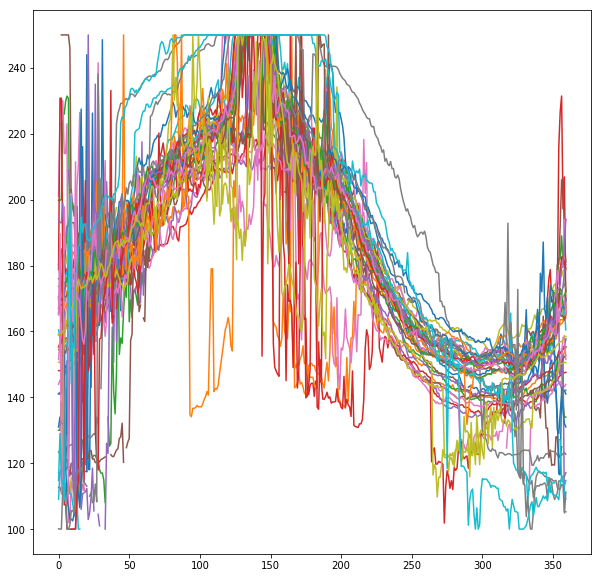

In [19]:
rfit = rfit_rshp[:,:,1]
plt.figure(figsize=(10,10))
plt.plot(rfit.T)
plt.show()

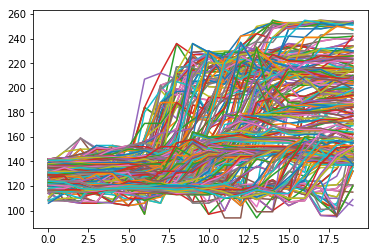

In [88]:
plt.plot(pupil_edge[0].T)
plt.show()

In [45]:
# sigmoid function
def curve_func(xval, a, b, c, d):
    return a+(b-a)/(1+10**((c-xval)*d))
# multiprocessing-ready fit to sigmoid function
def sigm_fit_mp(d):
    try:
        popt, pcov = curve_fit(curve_func, xdata=range(1,len(d)+1), ydata=d, p0=[100,200,10,0.5], bounds=([50, 100, 5, .05],[150, 250, 20, 5]), method='trf')
        ci = np.sqrt(np.diagonal(pcov))
    except RuntimeError:
        popt = np.nan*np.zeros(4); 
        ci = np.nan*np.zeros(4);
    return (popt, ci)

In [17]:
d = pupil_edge[0,:,:]
start = time()
for n in range(360):
    sigm_fit_mp(d[0])
end = time()
print(f'It took {end - start} seconds!')
 

It took 19.552050590515137 seconds!


In [46]:
d = pupil_edge[1,:,:]
n_proc = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=n_proc)
start = time()
# for n in range(360):
param_mp = [pool.apply_async(sigm_fit_mp, args=(d[n],)) for n in range(360)]
params_output = [result.get() for result in param_mp]
end = time()
print(f'It took {end - start} seconds!')

rfit = []
ci = []
for vals in params_output:
    rfit.append(vals[0])
    ci.append(vals[1])

It took 0.3557252883911133 seconds!


In [44]:
rfit_dogbox = rfit

In [47]:
rfit_trf = rfit

In [50]:
rfit_dogbox[1] - rfit_trf[1]

array([-2.53560444e-08, -8.60015348e-09, -3.10009796e-11,  8.42351788e-09])

In [ ]:
d = pupil_edge[deg_th,:]
    param_mp.append(pool.apply_async(sigm_fit_mp, args=(d,)))
params_output = [result.get() for result in param_mp]

In [18]:
pupil_edge[:,i] = eye_frame[((current_centY + r[i]*(np.sin(rad_range))).astype(int),(current_centX + r[i]*(np.cos(rad_range))).astype(int))]

In [ ]:
# without multiprocessing: 330ms
# with mp + bounds: 40-45ms
# with mp no bounds: 55ms

In [43]:
print(ci)

[[ 0.70158547  2.16000404  0.15087192  0.16247142]
 [ 6.70309202 15.62183965  1.27489763  0.04719962]
 [ 2.95451008  1.83010708  0.18805293  1.2440095 ]
 ...
 [ 8.44481812  1.72768393  1.14434692  0.12971847]
 [ 0.78775233  1.87113482  0.11253825  1.57587239]
 [ 2.24197911  3.17064275  2.5541012  25.63421722]]


In [39]:
print(ci)

(array([117.38806729, 159.01030486,  16.89161889,   0.73637719]), array([0.70158547, 2.16000404, 0.15087192, 0.16247142]))


In [ ]:
param_mp

In [ ]:
fit_thresh = 1
params = np.stack(params); ci = np.stack(ci)

# extract radius variable from parameters
rfit = params[:,2] - 1

# if confidence interval in estimate is > fit_thresh pix, set to to NaN
# then, remove if luminance goes the wrong way (e.g. from reflectance)
for th in range(0,360):
    rfit[th] = np.where(ci[th,2] > fit_thresh, np.nan, rfit[th])
    rfit[th] = np.where(ci[th,2] < 0, np.nan, rfit[th])

# interpolate because convolution will create large NaN holes
interp_x = [item for sublist in np.argwhere(np.isnan(rfit)) for item in sublist]
interp_xp = [item for sublist in np.argwhere(~np.isnan(rfit)) for item in sublist]
interp_fp = rfit[~np.isnan(rfit)]
rfit_interp_vals = np.interp(interp_x, interp_xp, interp_fp)
# replace values in rfit_interp if they were np.nan with the values found in interpolation
rfit_interp = rfit; j=0
for i in range(0,len(rfit_interp)):
    if np.isnan(rfit_interp[i]):
        rfit_interp[i] = rfit_interp_vals[j]
        j = j + 1

# median filter
rfit_interp = signal.medfilt(rfit_interp,3)

# subtract baseline (boxcar average using conv)
# because our points aren't perfectly centered on ellipse
filtsize = 30
rfit_conv = rfit - np.convolve(rfit_interp, np.ones(filtsize)/filtsize, mode='same')
# edges have artifact from conv, so set to NaNs
# could fix this by padding data with wraparound at 0 and 360deg before conv
#         rfit_conv[range(0,int(filtsize/2+1))] = np.nan
#         rfit_conv[range((len(rfit_conv)-int(filtsize/2-1)))] = np.nan

# save out video with detected edge of pupil outlined in green
rmin = 0.5 * (current_longaxis + current_shortaxis) - ranger
for th in range(1,261):
    try:
        eye_frame = cv2.circle(eye_frame, (int(round(current_centX+(rmin+rfit[th])*np.cos(th))),int(round(current_centY+(rmin+rfit[th])*np.sin(th)))), 1, (0,0,0), thickness=-1)
    except ValueError:
        pass

# save out data
if eyevid.get(cv2.CAP_PROP_POS_FRAMES) == 1:
    rfit_conv_xr = xr.DataArray(rfit_conv)
    rfit_conv_xr['frame'] = eyevid.get(cv2.CAP_PROP_POS_FRAMES)
#             rfit_conv_xr = xr.DataArray.rename(rfit_conv_xr, {'dim_1':'deg'})
if eyevid.get(cv2.CAP_PROP_POS_FRAMES) > 1:
    rfit_conv_temp = xr.DataArray(rfit_conv)
    rfit_conv_temp['frame'] = eyevid.get(cv2.CAP_PROP_POS_FRAMES)
#             rfit_conv_temp = xr.DataArray.rename(rfit_conv_temp, {'dim_1':'deg'})
    rfit_conv_xr = xr.concat([rfit_conv_xr, rfit_conv_temp], dim='frame', fill_value=np.nan)

# vidout.write(eye_frame)

# if cv2.waitKey(1) & 0xFF == ord('q'):
#     break

# vidout.release()
# cv2.destroyAllWindows()

In [ ]:
np.shape(r)

In [ ]:
# correlation across timepoints
timepoint_corr_rfit = np.corrcoef([rfit_conv_xr.isel(frame=1), rfit_conv_xr.isel(frame=2)]) # best way to make this apply to the entire dimension 'frame'? return to this later
plt.figure()
fig, ax = plt.subplots()
im = ax.imshow(timepoint_corr_rfit)
ax.set_title('correlation of radius fit across timepoints')
ax.set_xticks(np.arange(len(timepoint_corr_rfit)))
ax.set_yticks(np.arange(len(timepoint_corr_rfit)))
ax.set_xticklabels(range(1,len(timepoint_corr_rfit)+1))
ax.set_yticklabels(range(1,len(timepoint_corr_rfit)+1))
plt.savefig(fig_dir + 'corr_radius_fit.png', dpi=300)
plt.close()

# calculate mean as template
template = np.nanmean(rfit_conv_xr.values, 0)
plt.figure()
plt.plot(template)
plt.title('mean as template')
plt.savefig(fig_dir + 'mean_template.png', dpi=300)
plt.close()

plt.xcorr(rfit_conv_xr.isel(frame=1).values,template)
plt.title('mean as template')
plt.savefig(fig_dir + 'mean_template.png', dpi=300)
plt.title('rfit_conv template cross correlation')
plt.savefig(fig_dir + 'rfit_template_cc.png', dpi=300)
plt.close()

# xcorr of two random timepoints
t1 = 1; t2 = 2;
plt.figure()
plt.xcorr(rfit_conv_xr.sel(frame=t1).values, rfit_conv_xr.sel(frame=t2).values)
plt.title('xcorr of time ' + str(t1) + ' and ' + str(t2))
plt.savefig(fig_dir + 'xcorr_of_two_times.png', dpi=300)
plt.close()

# iterative fit to alignment
# start with mean as template
# on each iteration, shift individual frames to max xcorr with template
# then recalculate mean template
n = np.size(rfit_conv_xr.values, 0)
pupil_update = rfit_conv_xr.values
total_shift = np.zeros(n); peak = np.zeros(n)
c = total_shift;
for rep in range(0,12):
    print('starting rep='+str(rep)+' in iterative fit')
    # calculate and plot template
    template = np.nanmean(rfit_conv_xr.values, 0)
    plt.figure()
    plt.title('rep='+str(rep)+' in iterative fit')
    plt.plot(template)
    plt.savefig(fig_dir + 'rep'+str(rep)+'_template.png', dpi=300)
    plt.close()

    eyevid = cv2.VideoCapture(eyevidpath)

    vidsavepath = os.path.join(fig_dir, str(trial_name + '_pupil_rotation_rep' + str(rep) + '_' + eyeext + '.avi'))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vidout = cv2.VideoWriter(vidsavepath, fourcc, 60, (int(eyevid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(eyevid.get(cv2.CAP_PROP_FRAME_HEIGHT))))

    for frame_num in range(1,n):
        # for each frame, get correlation and shift
        xc = np.correlate(template, pupil_update[frame_num,:], 'same'); lags = range(-int(0.5*len(template)),int(0.5*len(template)))
        c[frame_num] = np.amax(xc); peaklag = np.argmax(xc)
        peak[frame_num] = lags[peaklag]
        total_shift[frame_num] = total_shift[frame_num] + peak[frame_num]
        pupil_update[frame_num,:] = np.roll(pupil_update[frame_num,:], int(peak[frame_num]))

    # histogram of correlations
    plt.figure()
    plt.hist(c)
    plt.savefig(fig_dir + 'rep'+str(rep)+'_correlation_hist.png', dpi=300)
    plt.close()

win = 3
shift_nan = -total_shift
shift_nan[c < 0.4] = np.nan

#     interp_x = [item for sublist in np.argwhere(np.isnan(shift_nan)) for item in sublist]
#     interp_xp = [item for sublist in np.argwhere(~np.isnan(shift_nan)) for item in sublist]
#     interp_fp = shift_nan[~np.isnan(shift_nan)]
#     shift_interp = np.interp(interp_x, interp_xp, interp_fp)

shift_smooth = np.convolve(shift_nan, np.ones(win)/win, mode='same')
shift_smooth = shift_smooth - np.nanmedian(shift_smooth)
shift_nan = shift_nan - np.nanmedian(shift_nan)

plt.figure()
plt.plot(shift_nan)
plt.savefig(fig_dir + 'shift_nan.png', dpi=300)
plt.close()
plt.figure()
plt.plot(shift_smooth)
plt.savefig(fig_dir + 'shift_smooth.png', dpi=300)
plt.close

# get eye data out of dataset
eye_pts = xr.Dataset.to_array(eye_ds).sel(variable='raw_pt_values')
eye_ell_params = xr.Dataset.to_array(eye_ds).sel(variable='ellipse_param_values')

# interpolate ellipse parameters to worldcam timestamps
eye_ell_interp_params = eye_ell_params.interp_like(xr.DataArray(worldTS), method=world_interp_method)

eye_theta = eye_ell_interp_params.sel(ellipse_params='theta')
eye_phi = eye_ell_interp_params.sel(ellipse_params='phi')
eye_longaxis= eye_ell_interp_params.sel(ellipse_params='longaxis')
eye_shortaxis = eye_ell_interp_params.sel(ellipse_params='shortaxis')
eye_centX = eye_ell_interp_params.sel(ellipse_params='centX')
eye_centY = eye_ell_interp_params.sel(ellipse_params='centY')

while(1):
    eye_ret, eye_frame = eyevid.read()

    if not eye_ret:
        break

    # debug with a few frames
    if eyevid.get(cv2.CAP_PROP_POS_FRAMES) > 1:
        break

    eye_frame = cv2.cvtColor(eye_frame, cv2.COLOR_BGR2GRAY)

    # get ellisepe parameters for this time
    current_time = int(eyevid.get(cv2.CAP_PROP_POS_FRAMES))
    current_theta = eye_theta.sel(frame=current_time).values[0]
    current_phi = eye_phi.sel(frame=current_time).values[0]
    current_longaxis = eye_longaxis.sel(frame=current_time).values[0]
    current_shortaxis = eye_shortaxis.sel(frame=current_time).values[0]
    current_centX = eye_centX.sel(frame=current_time).values[0]
    current_centY = eye_centY.sel(frame=current_time).values[0]

    rmin = 0.5 * (current_longaxis + current_shortaxis) - ranger
    for th in range(1,261):
        eye_frame = cv2.circle(eye_frame, (int(round(current_centX+(rmin+rfit[th])*np.cos(th))),int(round(current_centY+(rmin+rfit[th])*np.sin(th)))), 1, (0,0,0), thickness=-1)

    d = range(-20,20)
    for d1 in d:
        try:
            eye_frame = cv2.circle(eye_frame, (int(round(current_centX + d1 * np.cos(shift_smooth[current_time]+90))),int(round(current_centY + d1 * np.sin(shift_smooth[current_time]+90)))),1,(0,0,0),thickness=-1)
        except (ValueError, IndexError):
            pass
    eye_frame = cv2.circle(eye_frame, (int(current_centX),int(current_centY)),3,(0,0,0),thickness=-1)

    plt.figure()
    plt.imshow(eye_frame)
    plt.savefig(fig_dir + 'frame' + str(int(eyevid.get(cv2.CAP_PROP_POS_FRAMES))) + '_imshow.png', dpi=300)
    plt.close

    vidout.write(eye_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    vidout.release()
    cv2.destroyAllWindows()

return rfit_conv_xr, xr.DataArray(shift_smooth)

In [ ]:

rfit, shift = pupil_rotation_wrapper(data_path, trial_name, side_letter, eye_data, save_path)
    
    